In [2]:
from chainer import links as L
import chainer.functions as F
import chainer
from chainer import Chain, Link
from chainer import Parameter
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
from chainer import Variable, optimizers
import numpy as np
import PIL.Image
from PIL import ImageFilter
from io import BytesIO

mean = [103.939, 116.779, 123.68]   # BGR
#  modelVGG = VGG16Layers()

from IPython.display import clear_output, Image, display
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [3]:
# 基本入出力関数

# 配列の表示
def showarray(a, fmt='jpeg'):  # numpy 配列としての画像を表示
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# blob データを PIL 画像に変換
def blob2img(blob, mean=mean):
    blob = (np.dstack(blob)+ mean)[:,:,::-1]   # BGR 2 RGB
    return PIL.Image.fromarray(np.uint8(blob))

# blob データを画像として保存
def save_image(blobimg, it, fn = "frames"):
    def clip(a):
        return 0 if a<0 else (255 if a>255 else a)
    blobimg = np.vectorize(clip)(blobimg)
    image = blob2img(blobimg)
    image.save(fn+"/im_%05d.png"%it)
    return image

# チャネル間の相関行列
def ch_corr_matrix(ld):
    # 0次元目はバッチ数
    ch = ld.shape[1] # チャネル数
    size = ld[0][0].size  # チャネルあたりのデータ数
    cmatrix = F.reshape(ld, (ch,size)) # チャネルごとに１次元化した ch x size の配列を作る
    matrix = F.matmul(cmatrix, cmatrix,transb=True) / np.float32(ch*size) # 相関行列
    return matrix

In [ ]:
# layers_for_orig = ["conv4_1", "conv4_2", "conv4_3", "pool4"]
# layers_for_style =["conv1_1", "conv1_2", "pool1", "conv2_1", "conv2_2", "pool2", "conv3_1", "conv3_2", "conv3_3v3","pool3"]

lr = np.float32(400.0) # 学習係数
rr = np.float32(0.005) # 元画像/スタイル画像 比率
width = 224
CROPSIZE = (3,224,224)
iter = 5000  # 繰り返し回数

class MyVGG(VGG16Layers):
    def __init__(self):
        super(MyVGG, self).__init__()
        with self.init_scope():
            self.autopic = chainer.links.Parameter(self.genpic())
            self.opic = np.zeros(CROPSIZE ,dtype='f')
            self.spic = np.zeros(CROPSIZE ,dtype='f')
    
    def __call__(self, vimg, layers=['prob']):
         return self.myextract(vimg, layers=layers)
            
    def myextract(self,vimg, layers=['prob']):
        if vimg.data.ndim == 3:
            vimg = F.reshape(vimg,(1,3,224,224))
        return super(MyVGG,self).__call__(vimg,layers=layers)
    
    def genpic(self):
        genpic = np.random.uniform(-20,20,CROPSIZE ).astype(np.float32)
        return genpic
    
    def setpic(self, nimg):
        self.autopic.W.data = nimg
 
    def show(self,mode=0):
        if mode == 1 :
           img = blob2img(self.opic)
        elif mode == 2 :
           img = blob2img(self.spic)
        else :
           img = blob2img(self.autopic.data)  
        return img
        
    # ファイルから画像を生成
    def setImage(self,filename, withsmooth=False):
        img = PIL.Image.open(filename)
        nimg = VGGprepare(img)
        if withsmooth:
            # smimg = img.filter(ImageFilter.BLUR
            self.smimg = img.filter(ImageFilter.GaussianBlur(25))#  ImageFilter.GaussianBlur(radius=３０))  # ぼかしたイメージ
            nsmimg = VGGprepare(self.smimg)
            return nimg, nsmimg
        else:
            return nimg
        
    # autopic をもとに前向き伝搬
    def autoforward(self,layers=['prob']):
        h = self.myextract(self.autopic, layers=layers)
        return h
    
    # 処理対象画像をセット
    def setOimage(self,fname, layers=['vpool4']):
        print('Original image set',fname)
        self.opic, smpic =  self.setImage(fname, withsmooth=True)
        vimg = Variable(self.opic)
        h = self.myextract(vimg,layers=layers)  # 対象画像の特徴情報
        self.Ofeatures = h
        self.vsmimg = smpic
        
    # スタイル画像をセット
    def setSimage(self,fname, layers=['conv4_1']):
        print('Style image set',fname)
        self.spic =  self.setImage(fname)
        vimg = Variable(self.spic)
        h = self.myextract(vimg,layers=layers)
        cor = {}
        for l in h.keys():
            cor.update({l:ch_corr_matrix(h[l])})
        self.Sfeatures = h
        self.Scorr = cor

In [5]:
nn=MyVGG()

In [43]:
def Myforward(model, x, layers=['conv4_1','conv4_2','conv4_3','pool4']):
    return model(x,layers=layers)
    
def generate(nn,oimg,style,cont = False, itr=100,l1=['conv4_3','pool4'], l2=['conv4_1','conv4_2','conv4_3','pool4'],fn="frames", interval = 20, start = 0):
        nn.setOimage(oimg,l1)
        nn.setSimage(style,l2)
        if  cont == False:
            nn.setpic(nn.genpic())

        # train mode
        chainer.config.train=False
        chainer.config.enable_backprop=True

        optimizer = optimizers.Adam(alpha=2e+1, beta1=0.5)
        optimizer.setup(nn.autopic)

        oldx = nn.autopic.W  # 　前回の　x の値の初期値
        oldx.grad = np.zeros_like(oldx.data)  # grad はゼロにセット
        
        for times  in range (start,start+itr):
            nn.cleargrads()  # 微係数データを初期化

            loss = Variable(np.zeros(()).astype(np.float32))
            loss1 = Variable(np.zeros(()).astype(np.float32))  # 入力画像との自乗誤差
            loss2 = Variable(np.zeros(()).astype(np.float32))  # スタイル画像とのチャネル相関の自乗誤差

            #  l1での現画像と入力画像の誤差を求める
            x = nn.autopic.W
            efs = Myforward(nn,x,layers=list(set(l1+l2)))  # 前向き伝搬して指定した層のデータを取得
            for key in l1:
                ef = efs[key]
                of = nn.Ofeatures[key].data  # 先に保存してある対象画像の指定層データ
                loss1 += F.mean_squared_error(ef,of)   # 距離を誤差とする
 
            #  l2での現画像とスタイル画像のチャネル相関誤差を求める
            for key in l2:
                ef = efs[key]
                of = Variable(nn.Sfeatures[key].data) # 先に保存してあるスタイル画像の指定データ
                ecm = ch_corr_matrix(ef)   # チャネル相関マトリクス
                ocm = nn.Scorr[key].data  # 先に保存してあるスタイル画像のチャネル相関マトリクス
                loss2 += F.mean_squared_error(ecm, ocm)  # マトリクス間の自乗誤差

            loss3 = F.mean_squared_error(x, Variable(nn.vsmimg))    # 元の画像におおまかに近づけるための項
            
            loss = rr1*loss1+rr2*loss2+(1-rr1-rr2)*loss3
            loss.backward()

            xgrad = x.grad   #　 loss に対する入力の寄与を保存
            nn.cleargrads()  # nn 全体の微分データをクリア
            x.grad = xgrad
            # nn.autopic.W.grad = xgrad
            x = myoptimize(oldx, x, alpha = lr, beta = 0.5)
            # optimizer.update()

            def clipB(x):
                 return -mean[0] if x+mean[0] < 0 else (255.0 if x +mean[0] >255.0 else x)
            def clipG(x):
                 return -mean[1] if x+mean[1] < 0 else (255.0 if x +mean[1] >255.0 else x)
            def clipR(x):
                 return -mean[2] if x+mean[2] < 0 else (255.0 if x +mean[2] >255.0 else x)
            x[0].data = np.vectorize(clipB)(x[0].data) 
            x[1].data = np.vectorize(clipG)(x[1].data) 
            x[2].data = np.vectorize(clipR)(x[2].data)
            
            nn.autopic.W = x   # 自動生成画像を更新データで上書き
            if times % interval == 0:
                print("\n{}  {:10.5f}  = {:10.10f} +{:10.10f}+ {:10.10f}".format(times, 0+loss.data, 0+rr1*loss1.data, 0+rr2*loss2.data, 0+(1-rr1-rr2)*loss3.data)    )    
                showarray(blob2img(nn.autopic.W.data,mean=mean))
                save_image(x.data, times,fn=fn)                        
            print(times%10, end="")
            
            oldx = x    #  data が　　autoc.W と狂ってくるが grad しかつかわないのでかまわない

        print("\n{}  {:10.5e}  = {:10.5e} +{:10.5e}+ {:10.5e}".format(times, 0+loss.data, 0+rr1*loss1.data, 0+rr2*loss2.data, 0+(1-rr1-rr2)*loss3.data)    )    
        showarray(blob2img(nn.autopic.W.data,mean=mean))
        save_image(x.data, times,fn=fn)                        
            
def myoptimize(oldvimg, vimg, alpha=0.1, beta=0.5):
    vimg.data -= alpha * ( vimg.grad + beta * oldvimg.grad)
    return vimg

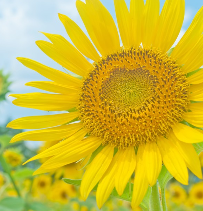

In [30]:
img = PIL.Image.open("himawari.png")
img.resize(np.array(img.size)//4)

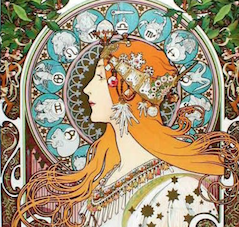

In [46]:
img = PIL.Image.open("Mucha.png")
img.resize(np.array(img.size)//1)

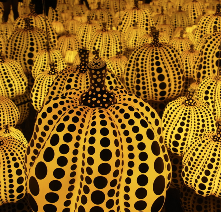

In [48]:
img = PIL.Image.open("kusama.png")
img.resize(np.array(img.size)//2)

# まず基本

Original image set himawari.png
Style image set Mucha.png

0  6492.57324  = 0.0000000000 +0.0000000000+ 6492.5732421875


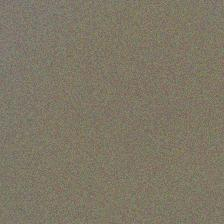

0123456789
10  2878.13354  = 0.0000000000 +0.0000000000+ 2878.1335449219


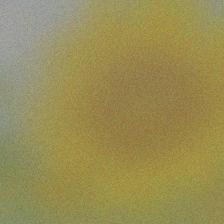

0123456789
20  1275.86584  = 0.0000000000 +0.0000000000+ 1275.8658447266


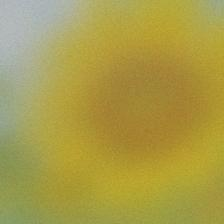

0123456789

In [91]:
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(0.00)
generate(nn,"himawari.png","Mucha.png",itr=30, fn="ex0")

# 元画像の３，４層特徴のみ

Original image set himawari.png
Style image set Mucha.png

0  34071.79297  = 34071.7929687500 +0.0000000000+ 0.0000000000


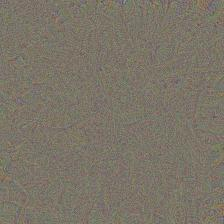

0123456789
10  14618.12109  = 14618.1210937500 +0.0000000000+ 0.0000000000


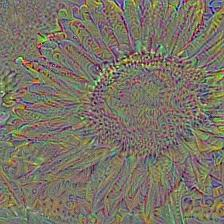

0123456789
20  8969.79004  = 8969.7900390625 +0.0000000000+ 0.0000000000


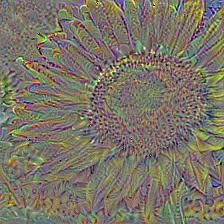

0123456789
30  7558.44922  = 7558.4492187500 +0.0000000000+ 0.0000000000


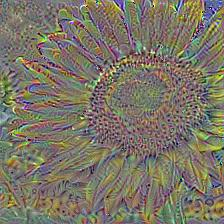

0123456789
40  6248.01855  = 6248.0185546875 +0.0000000000+ 0.0000000000


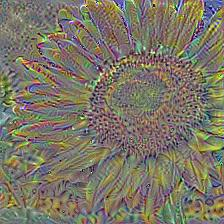

0123456789
49  5830.87988  = 5830.8798828125 +0.0000000000+ 0.0000000000


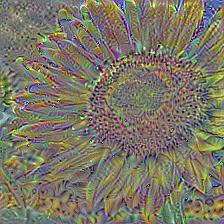

In [99]:
lr = np.float32(200.0) # 学習係数
rr1 = np.float32(1.)
rr2 = np.float32(0.)
generate(nn,"himawari.png","Mucha.png",itr=50, fn="ex2")

# スタイル画像特徴のみ

Original image set himawari.png
Style image set Mucha.png

0  43935.24609  = 0.0000000000 +43935.2460937500+ 0.0000000000


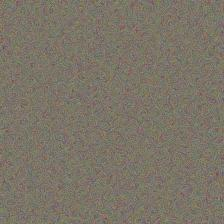

0123456789
10  21829.57617  = 0.0000000000 +21829.5761718750+ 0.0000000000


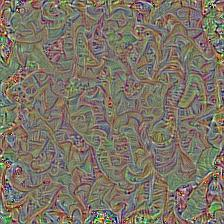

0123456789
20  7164.82520  = 0.0000000000 +7164.8251953125+ 0.0000000000


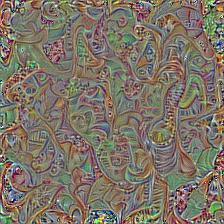

0123456789
29  2478.67505  = 0.0000000000 +2478.6750488281+ 0.0000000000


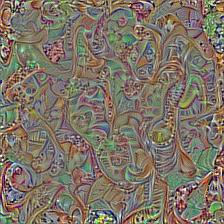

In [7]:
lr = np.float32(200.0) # 学習係数
rr1 = np.float32(0.00)
rr2 = np.float32(1)
generate(nn,"himawari.png","Mucha.png",itr=30, fn="stfr")

Original image set himawari.png
Style image set Mucha.png

0  8163.04834  = 681.4548339844 +1318.3953857422+ 6163.1982982661


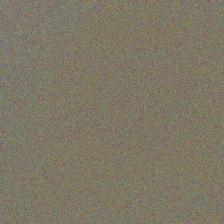

0123456789
10  3885.86792  = 452.7668762207 +507.5285034180+ 2925.5725498284


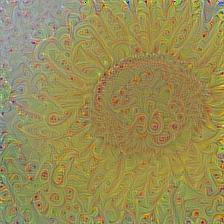

0123456789
20  2175.74976  = 347.8881835938 +376.4898986816+ 1451.3717790512


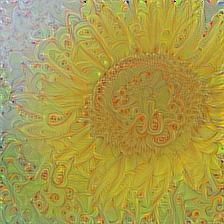

0123456789
30  1435.71863  = 333.8903198242 +320.0821838379+ 781.7460946697


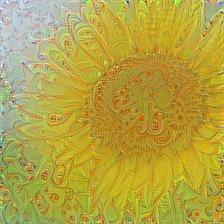

0123456789
40  1067.07617  = 292.6364135742 +305.9522094727+ 468.4875951556


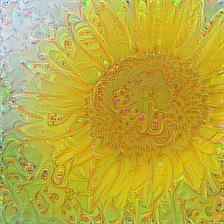

0123456789

In [83]:
lr = np.float32(2000.0) # 学習係数
rr1 = np.float32(0.02)
rr2 = np.float32(0.03)
generate(nn,"himawari.png","Mucha.png",itr=50, fn="ex3")

Original image set himawari.png
Style image set Mucha.png

0  7638.82422  = 34.0523872375 +1319.2950439453+ 6285.4767008188


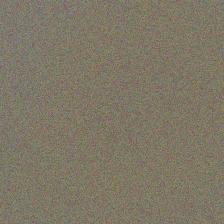

0123456789
10  3404.26489  = 46.4751815796 +432.7696838379+ 2925.0201844979


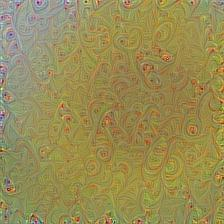

0123456789
20  1750.21228  = 48.5762710571 +277.6311035156+ 1424.0048805543


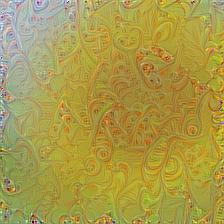

0123456789
30  1020.96820  = 49.4894218445 +227.5773620605+ 743.9014305931


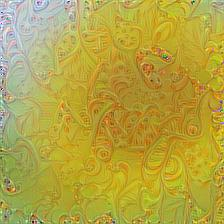

0123456789
40   687.62360  = 50.0002670288 +203.7797088623+ 433.8436386151


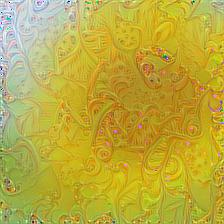

0123456789

In [84]:
lr = np.float32(500.0) # 学習係数
rr1 = np.float32(0.001)
rr2 = np.float32(0.03)
generate(nn,"himawari.png","Mucha.png",itr=50, fn="ex4")

Original image set himawari.png
Style image set kusama.png

0  14229.79395  = 170.3431243896 +7793.3569335938+ 6266.0941579119


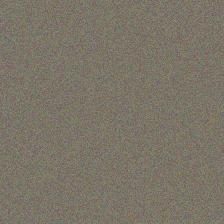

01234567890123456789
20  13493.69922  = 168.4444122314 +7508.4609375000+ 5816.7947752234


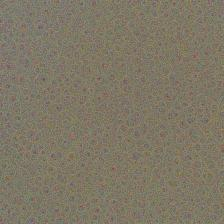

01234567890123456789
40  11689.84668  = 179.8435668945 +6062.7949218750+ 5447.2082563691


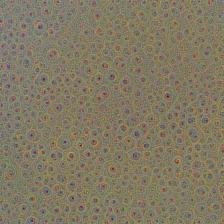

01234567890123456789
60  9628.28125  = 189.8524932861 +4284.8173828125+ 5153.6107756623


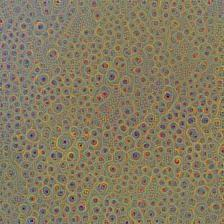

01234567890123456789
80  8150.99805  = 194.1468353271 +3076.6435546875+ 4880.2076162610


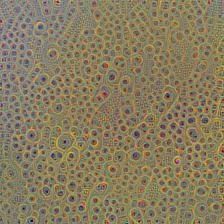

01234567890123456789
100  7152.21191  = 200.3042755127 +2343.6232910156+ 4608.2844690679


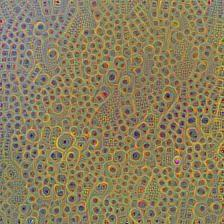

01234567890123456789
120  6425.06885  = 207.7619476318 +1876.1823730469+ 4341.1245958044


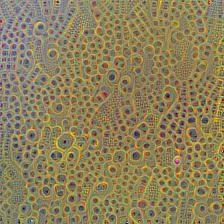

01234567890123456789
140  5857.59766  = 214.3704986572 +1558.5695800781+ 4084.6574691317


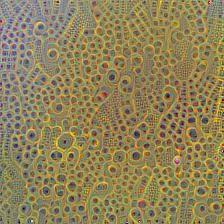

01234567890123456789
160  5392.26562  = 219.7592315674 +1330.3205566406+ 3842.1861408101


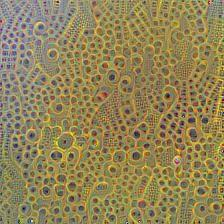

01234567890123456789
180  5001.16211  = 223.7940521240 +1162.5661621094+ 3614.8021257332


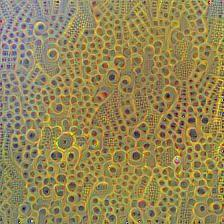

01234567890123456789
200  4665.22070  = 227.1137390137 +1035.6386718750+ 3402.4686709712


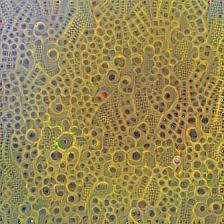

01234567890123456789
220  4372.31787  = 229.6165008545 +938.2356567383+ 3204.4657960548


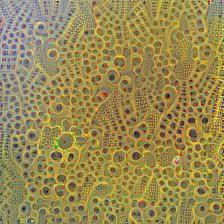

01234567890123456789
240  4112.76025  = 231.5323944092 +861.3640136719+ 3019.8638403388


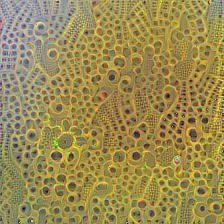

01234567890123456789
260  3880.54346  = 233.0098114014 +799.5650634766+ 2847.9685032854


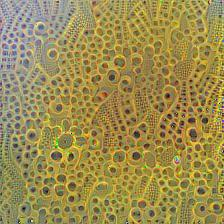

01234567890123456789
280  3671.41187  = 234.1893157959 +749.1365966797+ 2688.0859555483


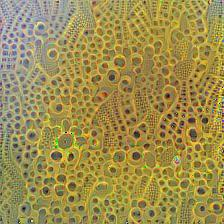

01234567890123456789
300  3481.42090  = 235.1903533936 +706.8785400391+ 2539.3520320879


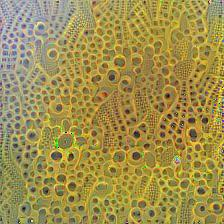

01234567890123456789
320  3308.52905  = 235.9396362305 +671.6164550781+ 2400.9730109796


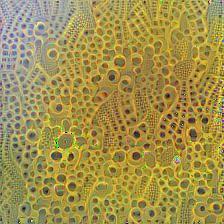

01234567890123456789
340  3150.45850  = 236.4922027588 +641.6342773438+ 2272.3321026722


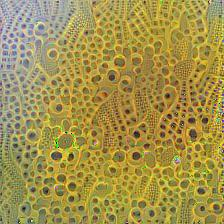

01234567890123456789
360  3005.62524  = 236.9170379639 +615.9228515625+ 2152.7854241085


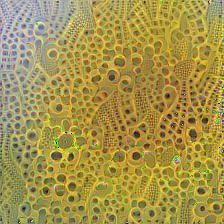

01234567890123456789
380  2872.30225  = 237.2352294922 +593.3882446289+ 2041.6787260204


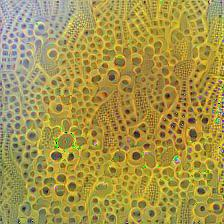

01234567890123456789
399  2.75536e+03  = 2.37450e+02 +5.74560e+02+ 1.94335e+03


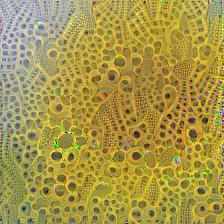

In [55]:
lr = np.float32(100.0) # 学習係数
rr1 = np.float32(0.005)
rr2 = np.float32(0.03)
generate(nn,"himawari.png","kusama.png", l1=['conv4_3','pool4'], l2=['conv4_1','conv4_2','conv4_3'], itr=400, fn="Hima",interval=20)

Original image set himawari.png
Style image set kusama.png

400  2749.46387  = 237.4560546875 +573.6453857422+ 1938.3624710538


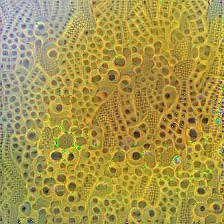

01234567890123456789
420  2636.17334  = 237.5733489990 +556.3355102539+ 1842.2643972454


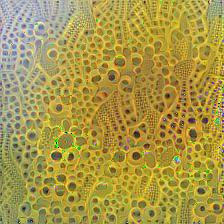

01234567890123456789
440  2531.55908  = 237.6605682373 +540.9514160156+ 1752.9471211721


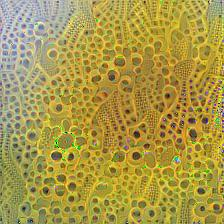

01234567890123456789
460  2435.03882  = 237.7325744629 +527.3099975586+ 1669.9962299915


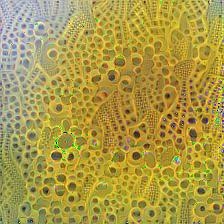

01234567890123456789
480  2345.91455  = 237.8024597168 +515.1755371094+ 1592.9365271703


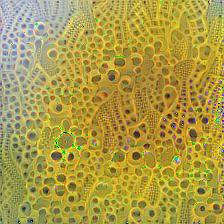

01234567890123456789
500  2263.50513  = 237.8496398926 +504.3222656250+ 1521.3333386357


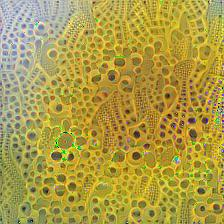

01234567890123456789
520  2187.16748  = 237.8179473877 +494.5918884277+ 1454.7577624098


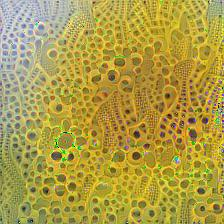

01234567890123456789
540  2116.27368  = 237.7169494629 +485.6631774902+ 1392.8936290589


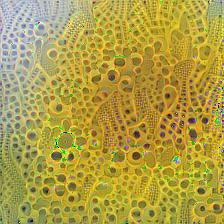

01234567890123456789
560  2050.52295  = 237.6015167236 +477.4399108887+ 1335.4814299157


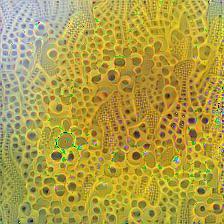

01234567890123456789
580  1989.45203  = 237.4364471436 +469.8766479492+ 1282.1389109515


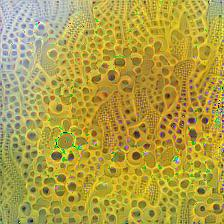

01234567890123456789
600  1932.68799  = 237.2978210449 +462.8153076172+ 1232.5748758772


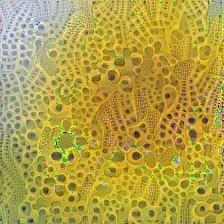

01234567890123456789
620  1880.00513  = 237.1959381104 +456.2821960449+ 1186.5269888769


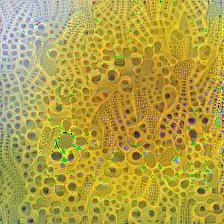

01234567890123456789
640  1831.10059  = 237.0917205811 +450.2383117676+ 1143.7704916499


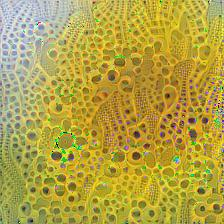

01234567890123456789
660  1785.66907  = 236.9705352783 +444.6452941895+ 1104.0532967935


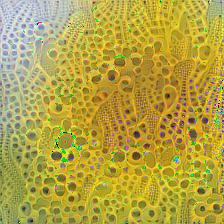

01234567890123456789
680  1743.38843  = 236.8016815186 +439.4524536133+ 1067.1342721053


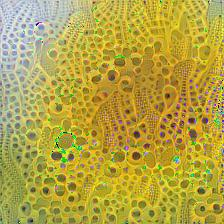

01234567890123456789
700  1704.05811  = 236.5995025635 +434.6098022461+ 1032.8488539867


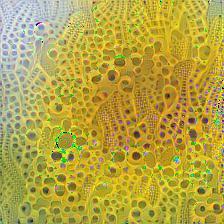

01234567890123456789
720  1667.53931  = 236.3765563965 +430.1668395996+ 1000.9959615049


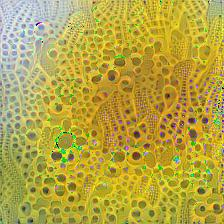

01234567890123456789
740  1633.60181  = 236.1373748779 +426.0572509766+ 971.4072615297


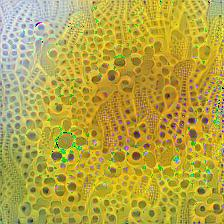

01234567890123456789
760  1601.94800  = 235.8916168213 +422.1486206055+ 943.9078831505


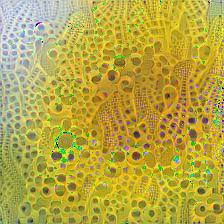

01234567890123456789
780  1572.40527  = 235.6615600586 +418.4188232422+ 918.3248991209


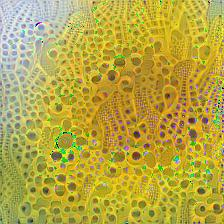

01234567890123456789
799  1.54622e+03  = 2.35462e+02 +4.15029e+02+ 8.95725e+02


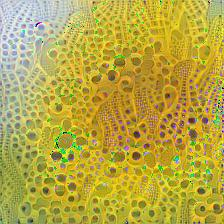

In [56]:
lr = np.float32(100.0) # 学習係数
rr1 = np.float32(0.005)
rr2 = np.float32(0.03)
generate(nn,"himawari.png","kusama.png", cont=True,l1=['conv4_3','pool4'], l2=['conv4_1','conv4_2','conv4_3'], itr=400, fn="Hima",interval=20,start=400)

In [ ]:
!convert -delay 12 -loop 0 -resize 300x Hima/*.jpg hima.gif